In [195]:
# Load Necessary Packages

%load_ext autoreload
%autoreload 2

import os
import holoviews as hv
import numpy as np
# import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import easygui
import glob
from src.fiberphotometry import ImportTDTData
from src.video import UsbVideo, Params4Motion
import src.FreezeAnalysis as fz
from src.plotting import FP_Plotting

Plotter = FP_Plotting()


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
# Set Path for Fiber Photometry Data

# set path to folder that contains all the sessions
Data_path = []
# Data_path = "../../pattern-24064-113630/"

if not Data_path:
    Data_path = easygui.diropenbox()

# change directory to the data path
os.chdir(Data_path)

list_of_SessFolders = os.listdir(Data_path)

# filter out any ini files
list_of_SessFolders = [f for f in list_of_SessFolders if not f.endswith('.ini')]
list_of_SessFolders.sort()

print("Available sessions:")
for idx, sessFolder in enumerate(list_of_SessFolders):
    print(f"|-- {idx}: {sessFolder}")

sessIdx = int(input("Enter session number you wish to analyze: "))

curr_sessFolder = os.path.abspath(list_of_SessFolders[sessIdx])

print(f"User selected session: {curr_sessFolder}")

# change directory to the session folder
os.chdir(curr_sessFolder)

# video_file = [f for f in os.listdir() if f.endswith('.avi')][0]
video_file = glob.glob('*.avi')[0]

print(f"Found video file: {video_file}")


Available sessions:

|-- 0: nia_02_5HT_cxtA_day_1

|-- 1: nia_02_5HT_cxtA_day_2

|-- 2: nia_02_5HT_cxtA_day_3

User selected session: /mnt/MegaDrive/Data_Shaharia/pattern-240604-113630/nia_02_5HT_cxtA_day_2

Found video file: pattern-240604-113630_nia_2-240612-110743_Cam1.avi

In [197]:
# Read Fiber Photometry Data
TDTDATACLASS = ImportTDTData(curr_sessFolder)
data = TDTDATACLASS.data

Found Synapse note file: /mnt/MegaDrive/Data_Shaharia/pattern-240604-113630/nia_02_5HT_cxtA_day_2/Notes.txt
read from t=0s to t=281.43s


In [228]:
video = UsbVideo(video_file, seconds4Cue=30)
video_params = video.video_params
video_dict = video.video_create4FreezeAnalysis

behavior_fps = video_params['fps']
total_behavior_frames = video_params['frame_count']

# Convert fiber time and TTL pulses to match behavior video frames
final_frame = ((data.info.duration.total_seconds()) * behavior_fps) # final frame of fiber recording
pulses = tuple(final_frame - (onset * behavior_fps) for onset in data.epocs.PtC0.onset)


# Here we are adjusting the start/end of the behavior data to match the fiber data. 
# This will be based on the second/shock pulse -> looking at x frames / x/fps sec before and after

frames_before_shock = video.preCue_onset
frames_after_shock = video.postCue_onset

video_dict['start'] = int(total_behavior_frames - (int(pulses[1]) + frames_before_shock))
video_dict['end'] = int(total_behavior_frames - (int(pulses[1]) - frames_after_shock))

In [229]:
print (f"Pulse times (s): {data.epocs.PtC0.onset}")
print (f"Total session duration (s): {data.info.duration.total_seconds()}")
print (f"FPS: {behavior_fps}")
print (f"Total frames found in behavior video: {total_behavior_frames}")
print (f"Final frame (fiber recording): {final_frame}")
for idx, pulse in enumerate(pulses):
    print (f"Pulse {idx} (from final frame): {pulse}")


Pulse times (s): [  6.85359104 188.20153344 250.32163328]

Total session duration (s): 281.432942

FPS: 20.0

Total frames found in behavior video: 5453.0

Final frame (fiber recording): 5628.65884

Pulse 0 (from final frame): 5491.5870192

Pulse 1 (from final frame): 1864.6281712

Pulse 2 (from final frame): 622.2261744000007

In [218]:
# %%output size=output_size4console
# Load Freezing Video and Crop Frame if Desired

img_crp, video_dict = fz.LoadAndCrop(video_dict, cropmethod="Box")

file: ./pattern-240604-113630_nia_2-240612-110743_Cam1.avi
total frames: 5453
nominal fps: 20.0
dimensions (h x w): 480,640


In [219]:
# Set Motion Threshold for behavior Video

if "A" in curr_sessFolder:
    cxt_idx = 0
elif "B" in curr_sessFolder:
    cxt_idx = 1
elif "C" in curr_sessFolder:
    cxt_idx = 2
else:
    raise ValueError(f"Unknown context: {curr_sessFolder}")

mt_cutoff = Params4Motion.MT_CUTOFF.value[cxt_idx]

# Detect Motion

h, w = Params4Motion.HEIGHT_WIDTH.value

In [203]:


Motion = fz.Measure_Motion(video_dict, mt_cutoff, SIGMA=Params4Motion.SIGMA.value) # x-axis
Motion_frameArr = np.arange(len(Motion))#/fps # y-axis

100%|██████████| 1199/1199 [00:01<00:00, 658.94it/s]


total frames processed: 1200



In [220]:
# NEW IDEA TO HANDLE ISSUES IN SHOCK DELAY
SHOCK_DELAY = Params4Motion.SHOCK_DELAY.value[cxt_idx]

ShockTime4Behavior = Params4Motion.SHOCKTIME.value + (SHOCK_DELAY / behavior_fps)
ShockTime4Fiber = Params4Motion.SHOCKTIME.value

# Calculate offset based on time_before_shock
offset = ShockTime4Behavior - (frames_before_shock / behavior_fps)

# Convert frame numbers to seconds and offset to match original timing
# time_in_seconds = (Motion_frameArr / behavior_fps) + offset
Motion_frameArr_TimeStamps = (Motion_frameArr / behavior_fps) + offset

# X axis data to use for plotting
# represents time before/after shock
Motion_frameArr_TS_Onset = Motion_frameArr_TimeStamps - ShockTime4Behavior
xLims = (np.floor(Motion_frameArr_TS_Onset[0]), np.ceil(Motion_frameArr_TS_Onset[-1]))


# Plot Motion Graph
plt_mt = hv.Curve((Motion_frameArr_TS_Onset, Motion), 'Time from shock (s)', 'Pixel Change', label='Motion').opts(
    height=h, width=w, line_width=1, color="steelblue",
    title="Motion Across Session", padding=0.0, show_grid=False, tools=['pan', 'box_zoom', 'reset'])

# Convert shock line position to seconds (always at 180s)
shock_line = hv.VLine(0, label='Shock Time').opts(
    color='red', line_dash='dashed')

# Combine plots with strict bounds
(plt_mt * shock_line).opts(margin=0)


:Overlay
   .Curve.Motion     :Curve   [Time from shock (s)]   (Pixel Change)
   .VLine.Shock_Time :VLine   [x,y]

In [205]:
from src.video import Params4Motion

FreezeThresh = Params4Motion.FREEZE_THRESH.value[cxt_idx]
MinDuration = Params4Motion.MIN_DURATION.value
print(f"FreezeThresh: {FreezeThresh}")
print(f"MinDuration: {MinDuration}")

Freezing = fz.Measure_Freezing(Motion, FreezeThresh, MinDuration)  

fz.SaveData(video_dict,Motion,Freezing,mt_cutoff,FreezeThresh,MinDuration)
print('Average Freezing: {x}%'.format(x=np.average(Freezing)))

# Create freezing area plot with adjusted time axis
plt_fz = hv.Area((Motion_frameArr_TS_Onset, Freezing*(Motion.max()/100)), 'Time from shock (s)', 'Motion').opts(
    color='lightgray',line_width=0,line_alpha=0)
plt_mt = hv.Curve((Motion_frameArr_TS_Onset, Motion), 'Time from shock (s)', 'Motion').opts(
    height=h,width=w,line_width=1, color='steelblue',
    title="Motion Across Session with Freezing Highlighted in Gray")
threshold_line = hv.HLine(y=FreezeThresh).opts(
    color='red',line_width=1,line_dash='dashed')
(plt_fz * plt_mt * threshold_line * shock_line).opts(
    padding=0.0,margin=0,show_grid=False)


FreezeThresh: 3500

MinDuration: 20

Average Freezing: 2.4166666666666665%

:Overlay
   .Area.I           :Area   [Time from shock (s)]   (Motion)
   .Curve.I          :Curve   [Time from shock (s)]   (Motion)
   .HLine.I          :HLine   [x,y]
   .VLine.Shock_Time :VLine   [x,y]

(-30.0, 30.0)

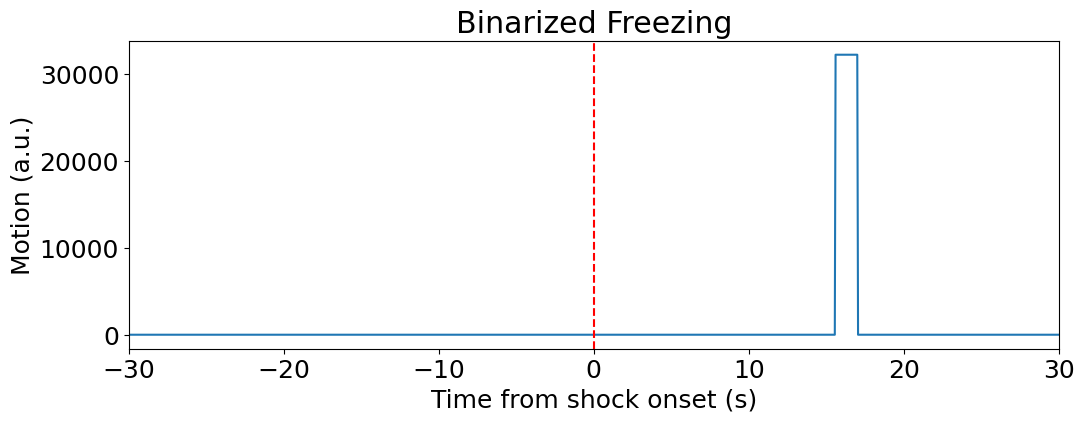

In [223]:
# Create binarized freezing data
freezing_binarized = Freezing*(Motion.max()/100)
#plt.plot(freezing_binarized)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(Motion_frameArr_TS_Onset, freezing_binarized)
ax.axvline(x=0, color='red', linestyle='--')
ax.set_ylabel('Motion (a.u.)')
ax.set_xlabel('Time from shock onset (s)')
ax.set_title('Binarized Freezing')
ax.set_xlim(xLims)

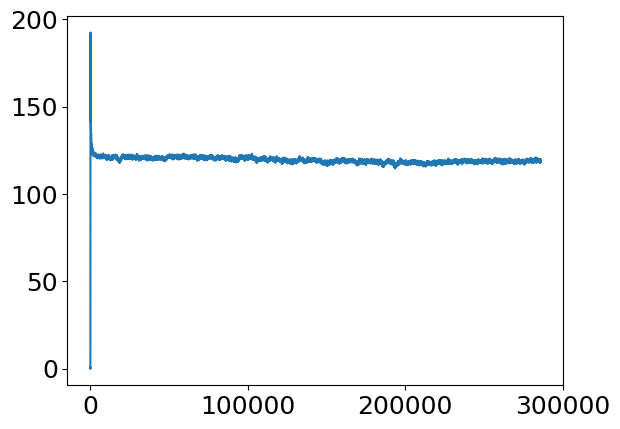

In [207]:
# Generate Raw Fiber Photometry Signal

plt.plot(data['streams'][TDTDATACLASS.ISOS_CHANNEL]['data'])

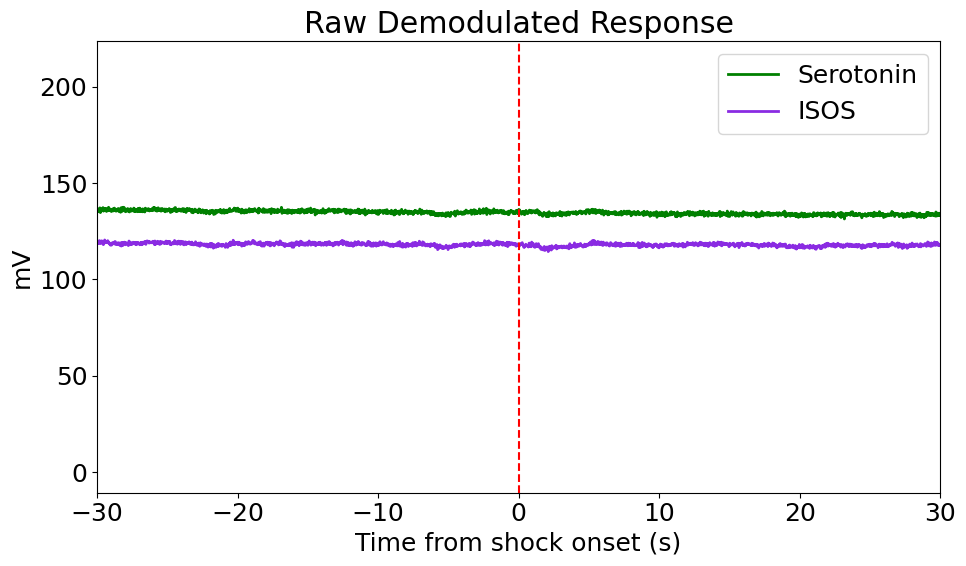

In [224]:
# Make a time array based on the number of samples and sample freq
matplotlib.rcParams['font.size'] = 18

Serotonin = TDTDATACLASS.DYNAMIC_CHANNEL  # Serotonin channel
ISOS = TDTDATACLASS.ISOS_CHANNEL  # Isosbestic channel
sampling_rate = data.streams[Serotonin].fs
sample_count = len(data.streams[Serotonin].data)
fiber_time = np.linspace(1, sample_count, sample_count)/sampling_rate



# Calculate offset to make shock appear at 180s
fiber_offset = Params4Motion.SHOCKTIME.value - data.epocs.PtC0.onset[1] 
fiber_time_offset = fiber_time + fiber_offset

# shock time now will be 0
fiber_time2use = fiber_time_offset - ShockTime4Fiber

# Plot both unprocessed demodulated stream
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)

# Plotting the traces with offset time
p1, = ax0.plot(fiber_time2use, data.streams[Serotonin].data, linewidth=2, color='green', label='Serotonin')
p2, = ax0.plot(fiber_time2use, data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

# Plotter.create_x_ticks4onset(ax0, x_tix_fib, x_lab_fib)
ax0.set_xlim(xLims)
ax0.set_xlabel('Time from shock onset (s)')
Plotter.create_ShockLine(ax0)
ax0.set_ylabel('mV')
ax0.set_title('Raw Demodulated Response')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()

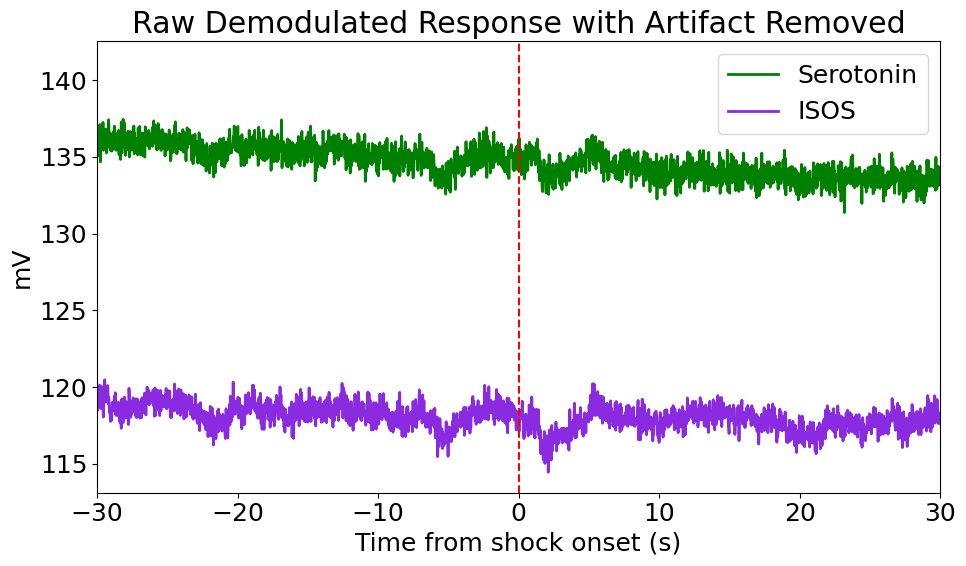

In [225]:
# Artifact Removal with adjusted time window
t = 8
inds = np.where(fiber_time>t)
ind = inds[0][0]
fiber_time_AR = fiber_time[ind:]
fiber_time_offset_AR = fiber_time_AR + fiber_offset  # Recalculate offset time after artifact removal
fiber_time2use_AR = fiber_time_offset_AR - ShockTime4Fiber
Serotonin_AR = data.streams[Serotonin].data[ind:]
ISOS_AR = data.streams[ISOS].data[ind:]

# Plot again at new time range
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)

# Plotting the traces with offset time
p1, = ax1.plot(fiber_time2use_AR, Serotonin_AR, linewidth=2, color='green', label='Serotonin')
p2, = ax1.plot(fiber_time2use_AR, ISOS_AR, linewidth=2, color='blueviolet', label='ISOS')

Plotter.create_ShockLine(ax1)
ax1.set_ylabel('mV')
ax1.set_xlim(xLims)
ax1.set_xlabel('Time from shock onset (s)')
ax1.set_title('Raw Demodulated Response with Artifact Removed')
ax1.legend(handles=[p1,p2], loc='upper right')
fig2.tight_layout()

In [210]:
def find_binned_avg(signal, N):
    binned_avg = [] 
    for i in range(0, len(signal), N):
        binned_avg.append(np.mean(signal[i:i+N-1]))
    return np.array(binned_avg)


# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value

binned_avg_Serotonin_AR = find_binned_avg(Serotonin_AR, N)
binned_avg_ISOS_AR = find_binned_avg(ISOS_AR, N)

fiber_time_binned = fiber_time[::N]
fiber_time_binned = fiber_time_binned[:len(binned_avg_Serotonin_AR)]
fiber_time_offset_binned = fiber_time_binned + fiber_offset  # Recalculate offset time after downsampling
fiber_time2use_binned = fiber_time_offset_binned - ShockTime4Fiber

# dFF calculation
x = binned_avg_ISOS_AR
y = binned_avg_Serotonin_AR
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all
dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)

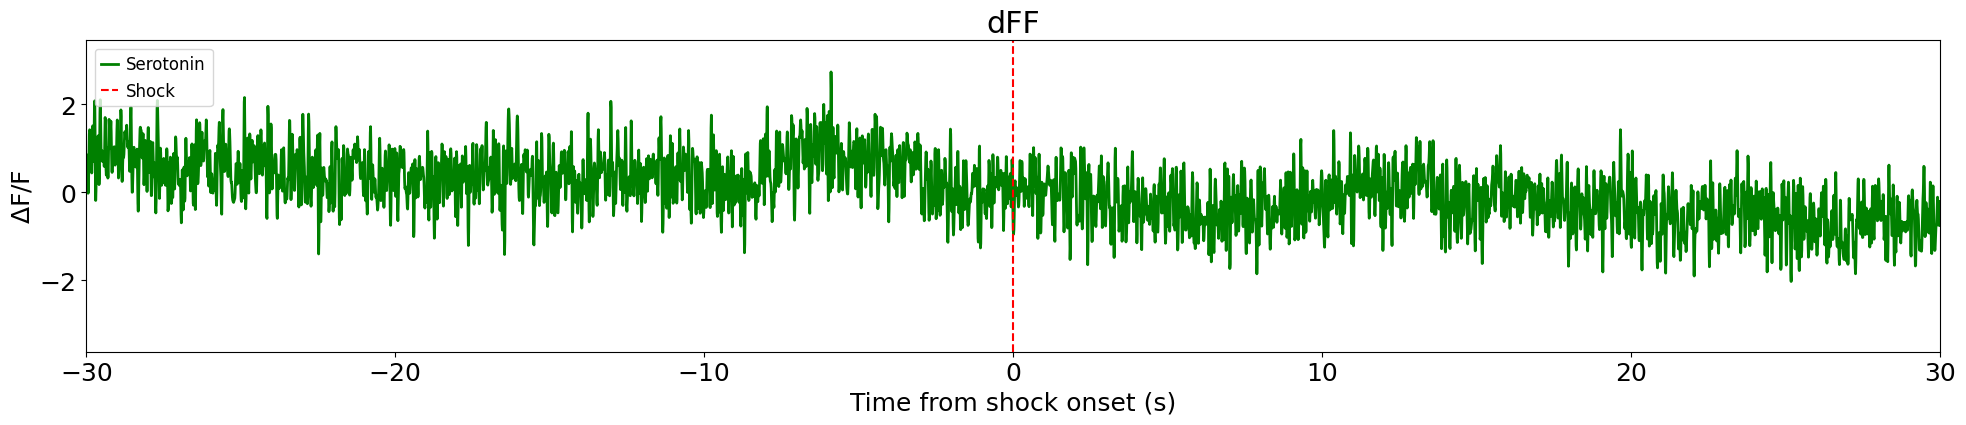

In [227]:
# Final dFF plot with offset time
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)

p1, = ax2.plot(fiber_time2use_binned, dFF, linewidth=2, color='green', label='Serotonin')
ax2.set_xlim(xLims)
Plotter.create_ShockLine(ax2)
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Time from shock onset (s)')
ax2.set_title('dFF')
ax2.legend(fontsize=12, markerscale=0.8, handlelength=1, handletextpad=0.5, labelspacing=0.5, loc='upper left')
fig3.tight_layout()

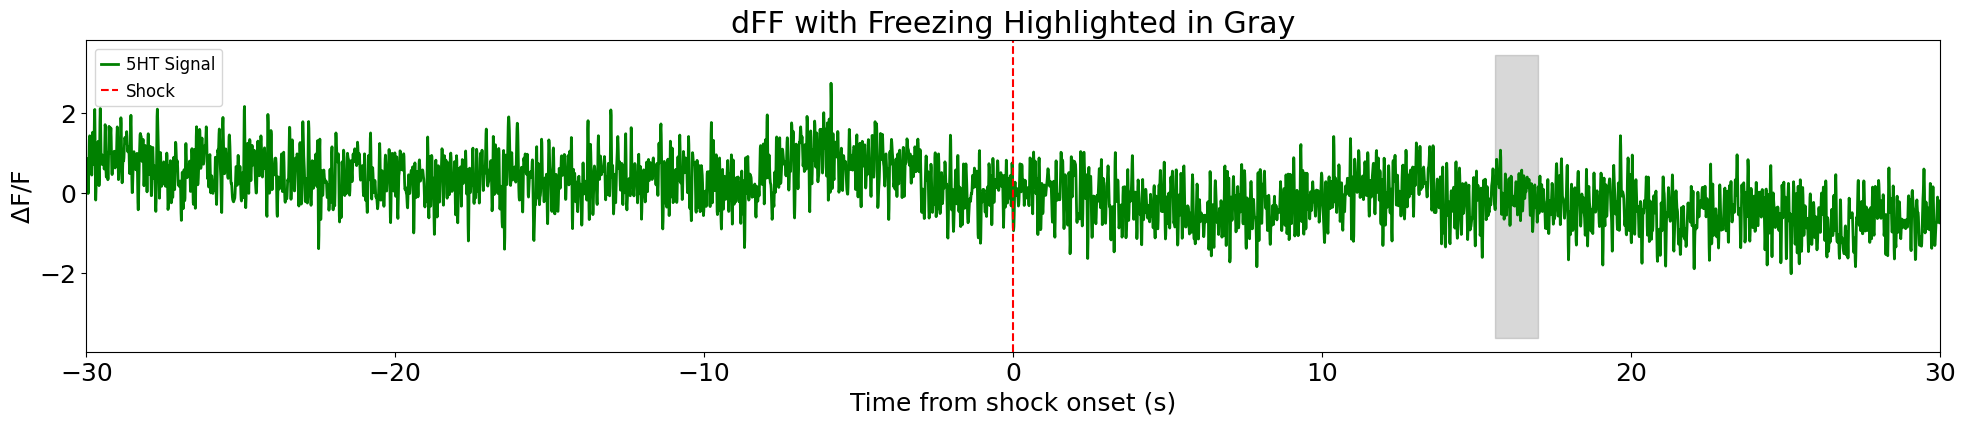

In [226]:
# Final dFF plot with freezing highlights
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311) 

# Plot dFF
p1, = ax2.plot(fiber_time2use_binned, dFF, linewidth=2, color='green', label='5HT Signal')

# Add freezing highlights using the same subplot configuration
ax2.fill_between(   Motion_frameArr_TS_Onset, 
                    ax2.get_ylim()[0],  # Use the natural y-limits from the dFF plot
                    ax2.get_ylim()[1],
                    where=Freezing>0, 
                    color='gray', 
                    alpha=0.3
                )

# Add shock line and formatting - keeping everything identical to original
ax2.set_xlim(xLims)
Plotter.create_ShockLine(ax2)
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Time from shock onset (s)')
ax2.set_title('dFF with Freezing Highlighted in Gray')
ax2.legend(fontsize=12, markerscale=0.8, handlelength=1, handletextpad=0.5, labelspacing=0.5, loc='upper left')
fig3.tight_layout()